# Data Selection

In [5]:
import yaml
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data.dataset import TensorDataset
from collections import Counter
from ptype.seed import seed_everything
from ptype.visualization_utils import ptype_map

## Select Before a Certain Year

In [4]:
config = 'config.yml'
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)
        
df = pd.read_parquet(conf['data_path'])
df = df[df["datetime"] < "2018-01-01 00:00:00"]
df.to_parquet('/glade/work/jwillson/mping_data_2017.parquet')

## Create and Save Custom Train/Val/Test Splits

In [12]:
dataset = 'mPING'
config = 'config/mping_072022.yml'
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)

df = pd.read_parquet(conf['data_path'])
total = df.shape[0]

In [13]:
features = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
outputs = conf['outputvars']
n_splits = conf['trainer']['n_splits']
train_size1 = conf['trainer']['train_size1']
train_size2 = conf['trainer']['train_size2']
seed = conf['trainer']['seed']
upsampling = 'none'

seed_everything(seed)

nov2015 = (df['datetime'] > '2015-11-26 23:00:00') & (df['datetime'] < '2015-11-29 00:00:00')
jan2017 = (df['datetime'] > '2017-01-09 23:00:00') & (df['datetime'] < '2017-01-18 00:00:00')
mar2017 = (df['datetime'] > '2017-03-08 23:00:00') & (df['datetime'] < '2017-03-19 00:00:00')
feb2021 = (df['datetime'] > '2021-02-09 23:00:00') & (df['datetime'] < '2021-02-20 00:00:00')
if dataset == 'ASOS':
    case_studies = [(df[nov2015], 'nov2015'), (df[jan2017], 'jan2017'), (df[mar2017], 'mar2017'), (df[feb2021], 'feb2021')]
    winter_storms = nov2015 | jan2017 | mar2017 | feb2021
else:
    case_studies = [(df[nov2015], 'nov2015'), (df[jan2017], 'jan2017'), (df[mar2017], 'mar2017')]
    winter_storms = nov2015 | jan2017 | mar2017

case_study_data = df[winter_storms]
data = df[~(winter_storms)]
data_size, cs_size = data.shape[0], case_study_data.shape[0]
assert (data_size+cs_size) == total

In [14]:
case_study_data.to_parquet(f'/glade/work/jwillson/{dataset}_case_studies.parquet')

In [15]:
for i, case_study in enumerate(case_studies):
    case_study[0].to_parquet(f'/glade/work/jwillson/{dataset}_{case_study[1]}.parquet')

In [12]:
# find the weights of each class in the two datasets
def class_weights(df):
    labels = np.argmax(df[outputs].to_numpy(), 1)

    weights = {k: v/labels.shape[0] for k,v in Counter(labels).items()}
    weights = {k: max(weights.values())/v for k, v in weights.items()}

    return weights

print(class_weights(data), class_weights(case_studies))

{0: 1.0, 1: 2.462092938163191, 2: 689.71225, 3: 59.11777058735295} {0: 1.0, 1: 1.0204851289963144, 3: 9.419303797468354, 2: 143.87915407854985}


In [27]:
# upsample the data in training and validation
def upsample(df, outputs, pl_scale, fzra_scale):
    df['label']= np.argmax(df[outputs].to_numpy(), 1)
    pl = df[df['label'] == 2]
    fzra = df[df['label'] == 3]
    df_pl = pd.concat([pl]*pl_scale, ignore_index=True)
    df_fzra = pd.concat([fzra]*fzra_scale, ignore_index=True)
    upsampled_df = pd.concat([df, df_pl, df_fzra], ignore_index=True)
    upsampling = f'pl{pl_scale}fzra{fzra_scale}'
    return upsampling, upsampled_df 

upsampling, data = upsample(data, outputs, 10, 2)

/glade/scratch/jwillson/ipykernel_153836/3623698386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label']= np.argmax(df[outputs].to_numpy(), 1)


### Tensorflow.keras

In [16]:
# split and preprocess the data
data['day'] = data['datetime'].apply(lambda x: str(x).split(' ')[0])
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size1, random_state=seed)
train_idx, test_idx = list(splitter.split(data, groups=data['day']))[0]
train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size2, random_state=seed)
train_idx, valid_idx = list(splitter.split(train_data, groups=train_data['day']))[0]
train_data, valid_data = train_data.iloc[train_idx], train_data.iloc[valid_idx]

test_data = pd.concat([test_data, case_study_data], ignore_index=True)

# print(class_weights(train_data), class_weights(valid_data), class_weights(test_data))
    
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(train_data[features])
x_valid = scaler_x.transform(valid_data[features])
x_test = scaler_x.transform(test_data[features])
y_train = train_data[outputs].to_numpy()
y_valid = valid_data[outputs].to_numpy()
y_test = test_data[outputs].to_numpy()

/glade/scratch/jwillson/ipykernel_27102/2744675085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['datetime'].apply(lambda x: str(x).split(' ')[0])


In [17]:
np.save(f'/glade/work/jwillson/{dataset}_x_train.npy', x_train)
np.save(f'/glade/work/jwillson/{dataset}_y_train.npy', y_train)
np.save(f'/glade/work/jwillson/{dataset}_x_val.npy', x_valid)
np.save(f'/glade/work/jwillson/{dataset}_y_val.npy', y_valid)
np.save(f'/glade/work/jwillson/{dataset}_x_test.npy', x_test)
np.save(f'/glade/work/jwillson/{dataset}_y_test.npy', y_test)

### PyTorch

In [28]:
# split and preprocess the data
data['day'] = data['datetime'].apply(lambda x: str(x).split(' ')[0])
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size1, random_state=seed)
train_idx, test_idx = list(splitter.split(data, groups=data['day']))[0]
train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size2, random_state=seed)
train_idx, valid_idx = list(splitter.split(train_data, groups=train_data['day']))[0]
train_data, valid_data = train_data.iloc[train_idx], train_data.iloc[valid_idx]

test_data = pd.concat([test_data, case_study_data], ignore_index=True)

# print(class_weights(train_data), class_weights(valid_data), class_weights(test_data))
    
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(train_data[features])
x_valid = scaler_x.transform(valid_data[features])
x_test = scaler_x.transform(test_data[features])
y_train = np.argmax(train_data[outputs].to_numpy(), 1)
y_valid = np.argmax(valid_data[outputs].to_numpy(), 1)
y_test = np.argmax(test_data[outputs].to_numpy(), 1)

# convert splits to torch tensor datasets
train_split = TensorDataset(
    torch.from_numpy(x_train).float(),
    torch.from_numpy(y_train).long()
)

val_split = TensorDataset(
    torch.from_numpy(x_valid).float(),
    torch.from_numpy(y_valid).long()
)

test_split = TensorDataset(
    torch.from_numpy(x_test).float(),
    torch.from_numpy(y_test).long()
)

In [15]:
torch.save(train_split, f'/glade/work/jwillson/train_split_{upsampling}.pt')
torch.save(val_split, f'/glade/work/jwillson/val_split_{upsampling}.pt')
torch.save(test_split, f'/glade/work/jwillson/test_split_{upsampling}.pt')

### Create separate transformed x_test and y_test for case studies based on fit_transform of train data

In [29]:
for i, case_study in enumerate(case_studies):
    x_test = scaler_x.transform(case_study[0][features])
    y_test = np.argmax(case_study[0][outputs].to_numpy(), 1)
    
    test_split = TensorDataset(
        torch.from_numpy(x_test).float(),
        torch.from_numpy(y_test).long()
    )

    torch.save(test_split, f"/glade/work/jwillson/{case_study[1]}_{upsampling}.pt")

In [18]:
for i, case_study in enumerate(case_studies):
    x_test = scaler_x.transform(case_study[0][features])
    y_test = case_study[0][outputs].to_numpy()
    
    np.save(f'/glade/work/jwillson/{dataset}_{case_study[1]}_xtest.npy', x_test)
    np.save(f'/glade/work/jwillson/{dataset}_{case_study[1]}_ytest.npy', y_test)

## Visualize Case Studies

In [133]:
df1['true_label'] = np.argmax(df1[outputs].to_numpy(), 1)

/glade/scratch/jwillson/ipykernel_94853/2890969169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['true_label'] = np.argmax(df1[outputs].to_numpy(), 1)


In [134]:
latN = 54.0
latS = 20.0
lonW = -63.0
lonE = -125.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'lime', 1:'dodgerblue', 2:'red', 3:'black'}

/glade/scratch/jwillson/ipykernel_94853/3944485012.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")


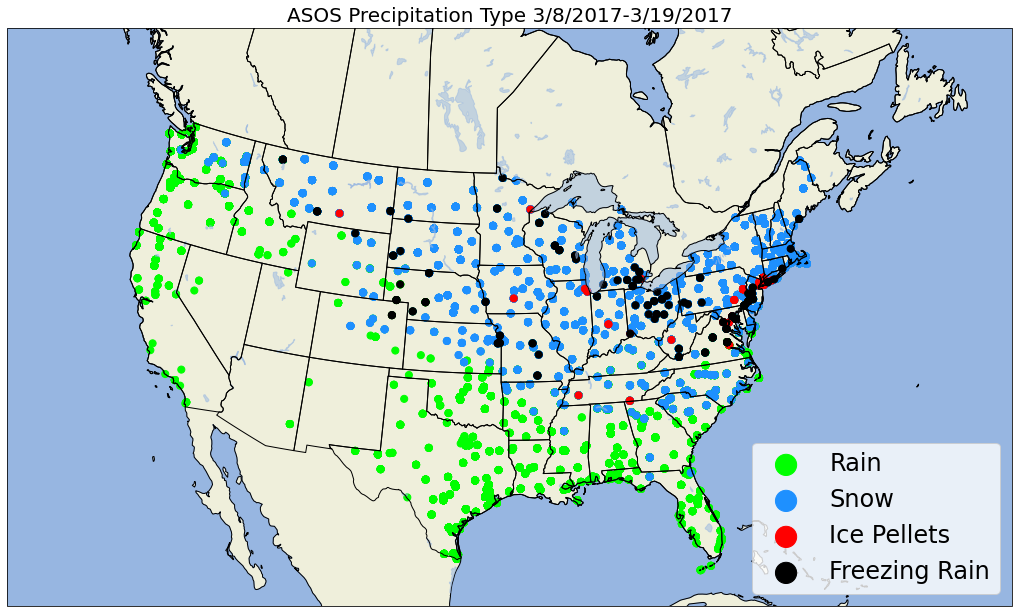

In [135]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(4):
    ax.scatter(df1["lon"][df1["true_label"] == i]-360,
               df1["lat"][df1["true_label"] == i],
               c=df1["true_label"][df1["true_label"] == i].map(colors),
               s=50, transform=ccrs.PlateCarree())

plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")
plt.title("ASOS Precipitation Type 3/8/2017-3/19/2017", fontsize=20)
plt.show()

In [ ]:
ptype_map('mping', '20170110 00:00:00', '20170117 23:00:00', 'mping2017_ice', 
          imgsavepath="/glade/u/home/jwillson/winter-ptype/gif_images", 
          gifsavepath="/glade/u/home/jwillson/winter-ptype/gifs", coords="na", duration=0.01)